In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import math
import os
import pandas as pd
import numpy as np
from tensorflow.python.framework import ops
import matplotlib
%matplotlib inline
plt.ion()
from random import randint
import time
from ipywidgets import FloatProgress
from IPython.display import display, clear_output
ops.reset_default_graph()
print("OK")

OK


In [3]:
"""csvファイルの読み込み"""
inputdata = pd.read_csv('response_spectra.csv', encoding='shift_jis',dtype = 'float',header=None)
a_df1 = inputdata.values
inputdata = pd.read_csv('response_spectra_ver2.txt', encoding='shift_jis',dtype = 'float',header=None)
a_df2 = inputdata.values
a_df=np.append(a_df1,a_df2,axis=0)
input_shape_rows   =16  #入力データの行
input_shape_columns=71  #入力データの列
output_shape= 5        #出力の

"""入力データと出力データを分けて読み込む"""
#x_vals = np.array([x[0:816] for x in a_df])
#y_vals = np.array([x[816:821] for x in a_df])
xdata = np.array([np.reshape(x[0:input_shape_rows*input_shape_columns],(input_shape_rows,input_shape_columns)) for x in a_df])
ydata  = np.array([x[input_shape_rows*input_shape_columns:input_shape_rows*input_shape_columns+output_shape] for x in a_df])
print(np.shape(a_df))

(70000, 1141)


In [4]:
"""結果を再現可能にするためのランダムシードを作成"""
seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)
print("OK")

OK


In [9]:
"""正規化の定義"""
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max-col_min) 

"""データの最大値と最小値を保存"""
col_max0 = ydata.max(axis=0)
col_min0 = ydata.min(axis=0) 

"""正規化の実行"""
#x_vals0 = np.nan_to_num(normalize_cols(x_vals))   #入力の正規化は不要
#ydata_0 = np.nan_to_num(normalize_cols(ydata))

"""訓練データとテストデータを8：2に分割するためのインデックスを作成"""
train_indices = np.random.choice(len(xdata), round(len(xdata)*0.8), replace=False)  #訓練データに使うindex
test_indices  = np.array(list(set(range(len(xdata))) - set(train_indices)))         #テストデータに使うindex

"""入力データを訓練とテストにわけた"""
train_xdata   = xdata[train_indices]    #入力データの訓練集合
test_xdata    = xdata[test_indices]     #入力データのテスト集合

"""出力データを訓練とテストにわけた"""
train_ydata   = ydata[train_indices]  #出力データの訓練集合(正規化済み)
test_ydata    = ydata[test_indices]   #出力データのテスト集合(正規化済み)
#test_ydata_origin    = ydata[test_indices] #出力データのテスト集合(正解値)
print(col_max0)
print(col_min0)

[14.997232    1.          1.          9.99997779  2.094343  ]
[ 0.500058   -1.         -1.          0.10018958  0.448801  ]


In [87]:
"""ネットワーク構造のパラメータを設定"""
batch_size          = 200                     #一回の学習に使うデータの数
#learning_rate       = 0.005
evaluation_size     = 200                     #一回のテストに使うデータの数  #len(test_indices) 
image_height        = train_xdata[0].shape[0]  #行
image_width         = train_xdata[0].shape[1]  #列
target_size         = output_shape
num_channels        = 1                        # greyscale = 1 channel
conv1_features      = 8                        #1回目の畳み込みの枚数
filter_size1        = 10
conv2_features      = 16                       #2回目の畳み込みの枚数
filter_size2        = 6
max_pool_size1      = 2                        #プーリング層
max_pool_size2      = 2                        # プーリング層
fully_connected_size1 = 80#120                     #全結合層のノード数?
fully_connected_size2 = 50
fully_connected_size3 = 30
print("OK")

OK


In [88]:
"""入力データのサイズの格納庫作成"""
x_input_shape = (batch_size, image_height, image_width,num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
"""出力データのサイズと格納庫作成"""
y_target = tf.placeholder(tf.float32, shape=(batch_size,output_shape))   


"""入力データのサイズの格納庫作成"""
test_x_input_shape = (evaluation_size, image_height, image_width,num_channels)
test_x_input = tf.placeholder(tf.float32, shape=test_x_input_shape)
"""出力データのサイズと格納庫作成"""
test_y_target = tf.placeholder(tf.float32, shape=(evaluation_size, output_shape))  


"""テスト用入力データのサイズと格納庫作成""" #評価は、一部のデータに対して行う
eval_x_input_shape = (len(test_xdata), image_height, image_width,num_channels)
eval_x_input = tf.placeholder(tf.float32, shape=eval_x_input_shape)
"""テスト用出力データのサイズと格納庫作成"""
eval_y_target = tf.placeholder(tf.float32, shape=(len(test_xdata),output_shape))
print("OK")

OK


In [89]:
"""ネットワーク構造の決定と準備""" #±2σの切断正規分布からランダムに取り出したテンソルを生成する。stddev: 生成する切断正規分布の標準偏差
"""畳み込み層の重みとバイアスの準備"""
#一枚目の畳み込み[1行,6列,60枚]
conv1_weight = tf.Variable(tf.truncated_normal([1, filter_size1,num_channels,  conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.truncated_normal([conv1_features], dtype=tf.float32))
#2枚目の畳み込み[1行,4列,30枚]
conv2_weight = tf.Variable(tf.truncated_normal([1, filter_size2 , conv1_features, conv2_features],stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.truncated_normal([conv2_features], dtype=tf.float32))

"""全結合層の重みとバイアスを準備"""
resulting_width = int(((image_width-filter_size1+1)/max_pool_size1-filter_size2+1)/max_pool_size2)# // (max_pool_size1 * max_pool_size2)
resulting_height = image_height# // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features  #全結合層(プーリングマップサイズ*チャネル数)
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1,dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, fully_connected_size2],stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([fully_connected_size2], stddev=0.1, dtype=tf.float32))  #(訓練データ数,出力個数=5)
full3_weight = tf.Variable(tf.truncated_normal([fully_connected_size2,fully_connected_size3],stddev=0.1, dtype=tf.float32))
full3_bias = tf.Variable(tf.truncated_normal([fully_connected_size3], stddev=0.1, dtype=tf.float32))
full4_weight = tf.Variable(tf.truncated_normal([fully_connected_size3, target_size],stddev=0.1, dtype=tf.float32))
full4_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))
print("OK")

OK


In [90]:
"""畳み込みと全結合を計算する関数作成"""
def my_conv_net(input_data):
    # 1枚目の畳み込み
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='VALID')#ゼロパディングを利用する場合はSAMEを指定
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, 1, max_pool_size1, 1],strides=[1, 1, max_pool_size1, 1], padding='VALID')
    
    # 2枚目の畳み込み　Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='VALID')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, 1, max_pool_size2, 1],strides=[1, 1, max_pool_size2, 1], padding='VALID')

    # 全結合層の引き渡すための並び替え Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = tf.cast(final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3], tf.float32) #6120
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # 全結合層
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    fully_connected2 = tf.nn.relu(tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias))
    fully_connected3 = tf.nn.relu(tf.add(tf.matmul(fully_connected2, full3_weight), full3_bias))

    final_model_output = tf.add(tf.matmul(fully_connected3, full4_weight), full4_bias)
    
    return final_model_output
print("OK")

OK


In [91]:
"""畳み込みと全結合層の結果を受け取る"""
model_output      = my_conv_net(     x_input)
test_model_output = my_conv_net(test_x_input)
eval_model_output = my_conv_net(eval_x_input) #テスト用

"""全結合層からの出力を出力層の活性化関数にいれる"""
prediction      = model_output#tf.nn.relu(     model_output)          #ReLU関数を使用した
test_prediction = test_model_output#tf.nn.relu(test_model_output)
eval_prediction = eval_model_output#tf.nn.relu(eval_model_output)
print(np.shape(prediction))
print(np.shape(test_prediction))
print(np.shape(eval_prediction))

(200, 5)
(200, 5)
(14000, 5)


In [92]:
"""損失を計算"""
def cal_loss(retsu,est_y,tar_y):
    return tf.reduce_mean(tf.abs((est_y[:,retsu]-tar_y[:,retsu])))/(col_max0[retsu:retsu+1]-col_min0[retsu:retsu+1])

loss      = tf.reduce_mean([cal_loss(retsu,prediction,tf.cast(y_target,tf.float32)) for retsu in range(5)])
test_loss = tf.reduce_mean([cal_loss(retsu,test_prediction,tf.cast(test_y_target,tf.float32)) for retsu in range(5)])
print("OK")

OK


In [93]:
"""勾配降下法と最適化"""
my_optimizer =tf.train.AdamOptimizer(0.0005)#tf.train.MomentumOptimizer(learning_rate, 0.9)# 
train_step = my_optimizer.minimize(loss)
print("OK")

OK


In [94]:
"""精度"""
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return (100. * num_correct/batch_predictions.shape[0])
print("OK")

OK


In [95]:
"""推定結果や精度を保存するリスト準備"""
list_train_loss = []
list_test_loss=[]
print("OK")

OK


In [96]:
sess=tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print("OK")

OK


Generation: 50000. Loss = 0.016304102 ,  Test Loss = 0.014219184


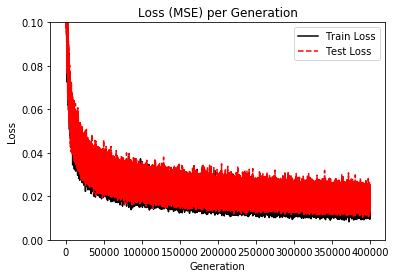

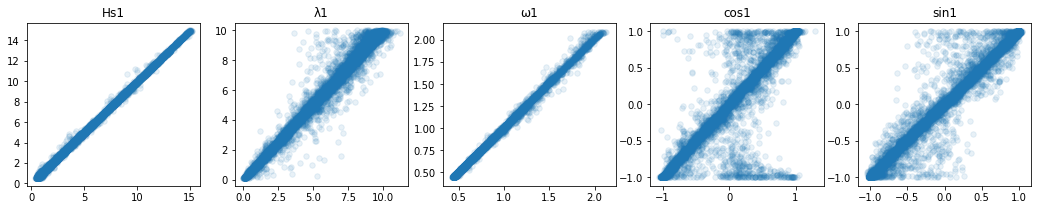

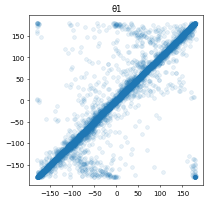

In [100]:
siz = 10
dat = np.zeros((siz, siz))
fig, (axe_H,axe_lambda, axe_w,axe_cos,axe_sin) = plt.subplots(ncols=5, figsize=(15,5))

"""計算始める"""
print("start")
generations         = 50000  #計算回数
eval_every          = 100    #100世代ごとにプロット
for i in range(generations):
    """訓練にデータの作成"""
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]      #入力データの訓練集合からバッチサイズ分取り出す
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_ydata[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss,temp_train_preds = sess.run( [loss,prediction], feed_dict=train_dict)
    
    """テストデータで計算"""
    test_index = np.random.choice(len(test_xdata), size=evaluation_size)
    test_x = test_xdata[test_index]
    test_x = np.expand_dims(test_x, 3)
    test_y = test_ydata[test_index]
    test_dict = {test_x_input: test_x, test_y_target: test_y}
    temp_test_loss= sess.run(test_loss, feed_dict=test_dict)
    

    """訓練データとテストデータそれぞれの誤差を格納"""
    list_train_loss.append(temp_train_loss)
    list_test_loss.append(temp_test_loss)
    
    if (i+1) % eval_every == 0:
        """テストデータで計算"""
        eval_x = test_xdata
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_ydata
        eval_dict = {eval_x_input: eval_x, eval_y_target: eval_y}
        eval_preds = sess.run(eval_prediction, feed_dict=eval_dict)
    
        clear_output(wait = True)
        plt.close()

        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_train_loss)+" ,  Test Loss = "+str(temp_test_loss))
        #グラフをプロット
        plt.plot(list_train_loss, 'k-', label='Train Loss')
        plt.plot(list_test_loss, 'r--', label='Test Loss')
        plt.title('Loss (MSE) per Generation')
        plt.ylim(0,0.10)
        plt.legend(loc='upper right')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()
        
        axe_H.scatter(eval_preds[:,0:1],test_ydata[:,0:1],s=30, alpha=0.1)#*(col_max0[0:1] - col_min0[0:1]) + col_min0[0:1]
        axe_H.set_title('Hs1')
        axe_w.scatter(eval_preds[:,4:5],test_ydata[:,4:5],s=30, alpha=0.1)#*(col_max0[4:5] - col_min0[4:5]) + col_min0[4:5]
        axe_w.set_title('ω1')
        axe_cos.scatter(eval_preds[:,1:2],test_ydata[:,1:2],s=30, alpha=0.1)#*(col_max0[1:2] - col_min0[1:2]) + col_min0[1:2]
        axe_cos.set_title('cos1')
        axe_sin.scatter(eval_preds[:,2:3],test_ydata[:,2:3],s=30, alpha=0.1)#*(col_max0[2:3] - col_min0[2:3]) + col_min0[2:3]
        axe_sin.set_title('sin1')
        axe_lambda.scatter(eval_preds[:,3:4],test_ydata[:,3:4],s=30, alpha=0.1)#*(col_max0[3:4] - col_min0[3:4]) + col_min0[3:4]
        axe_lambda.set_title('λ1')
        fig.set_size_inches(18,3)
        display(fig)
        #time.sleep(.2)
        #axe_loss.cla()
        axe_H.cla()
        axe_w.cla()
        axe_cos.cla()
        axe_sin.cla()
        axe_lambda.cla()
        
        D_kaku=np.zeros(len(eval_preds[:,4:5]))
        y_val_kaku=np.zeros(len(eval_preds[:,4:5]))
        for i in range(len(eval_preds[:,4:5])):
            D_kaku[i]=math.atan2(eval_preds[i][2:3],eval_preds[i][1:2])*180/np.pi
            y_val_kaku[i]=math.atan2(test_ydata[i][2:3],test_ydata[i][1:2])*180/np.pi

        plt.figure(figsize=(4.5,4.5),dpi=50)
        plt.scatter(D_kaku,y_val_kaku,s=30, alpha=0.1)
        plt.title('θ1')
        plt.show()

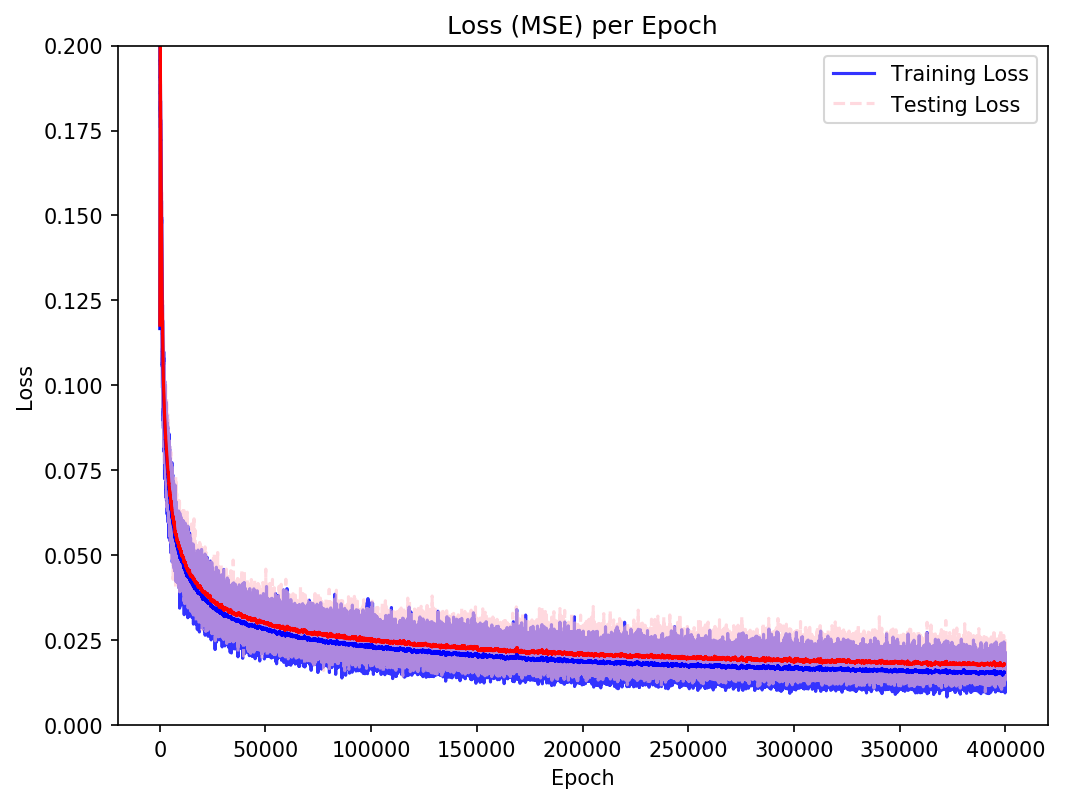

400000


In [103]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(list_train_loss, 'k-', label='Training Loss',alpha=0.8,color='blue')
plt.plot(list_test_loss, 'r--', label='Testing Loss',alpha=0.6,color='pink')
conv1_loss=np.ones(500)/500
mean_loss_train=np.convolve(np.array(list_train_loss),conv1_loss,mode='same')
mean_loss_test=np.convolve(np.array(list_test_loss),conv1_loss,mode='same')
plt.plot(mean_loss_train[:len(mean_loss_train)-500],color='blue')
plt.plot(mean_loss_test[:len(mean_loss_train)-500],color='red')
plt.title('Loss (MSE) per Epoch')
plt.ylim(0,0.2)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(len(mean_loss_train))

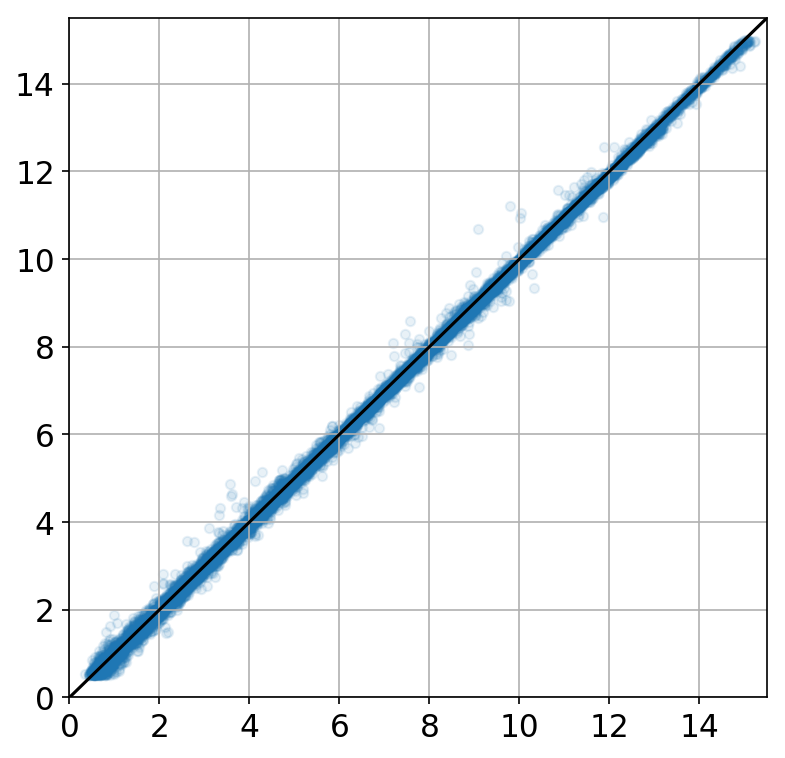

In [107]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(eval_preds[:,0],test_ydata[:,0],s=20, alpha=0.10)
plt.plot([0,15.5],[0,15.5],color='black')
plt.grid()
plt.xlim(0,15.5)
plt.ylim(0,15.5)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=8)
plt.locator_params(axis='x',nbins=8)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.show()

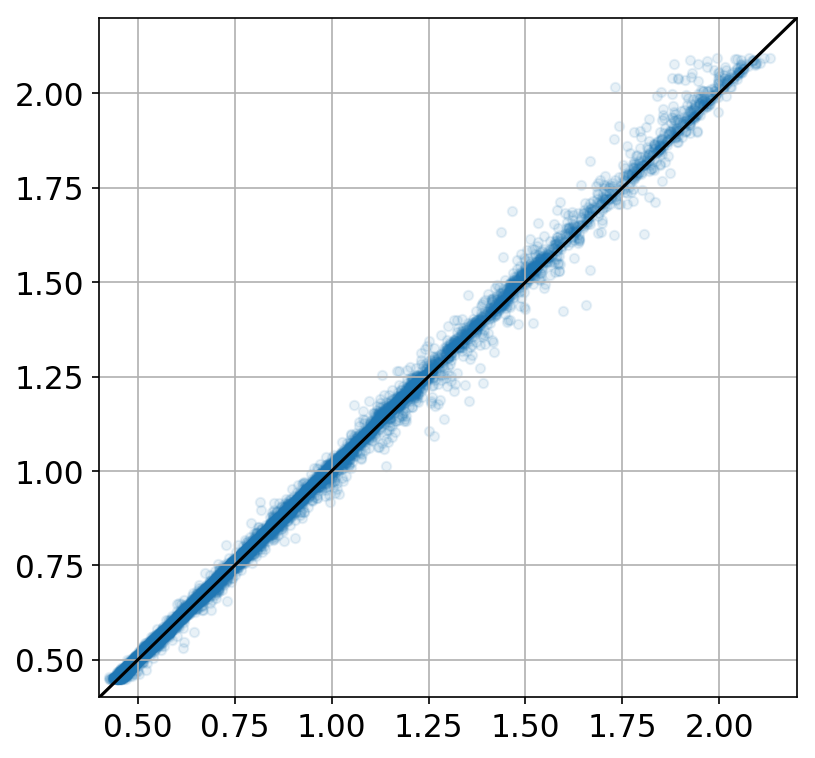

(14000, 5)


In [113]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(eval_preds[:,4],test_ydata[:,4],s=20, alpha=0.1)
plt.grid()
plt.plot([0.4,2.2],[0.4,2.2],color='black')
plt.xlim(0.4,2.2)
plt.ylim(0.4,2.2)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=8)
plt.locator_params(axis='x',nbins=8)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.show()
print(np.shape(eval_preds))

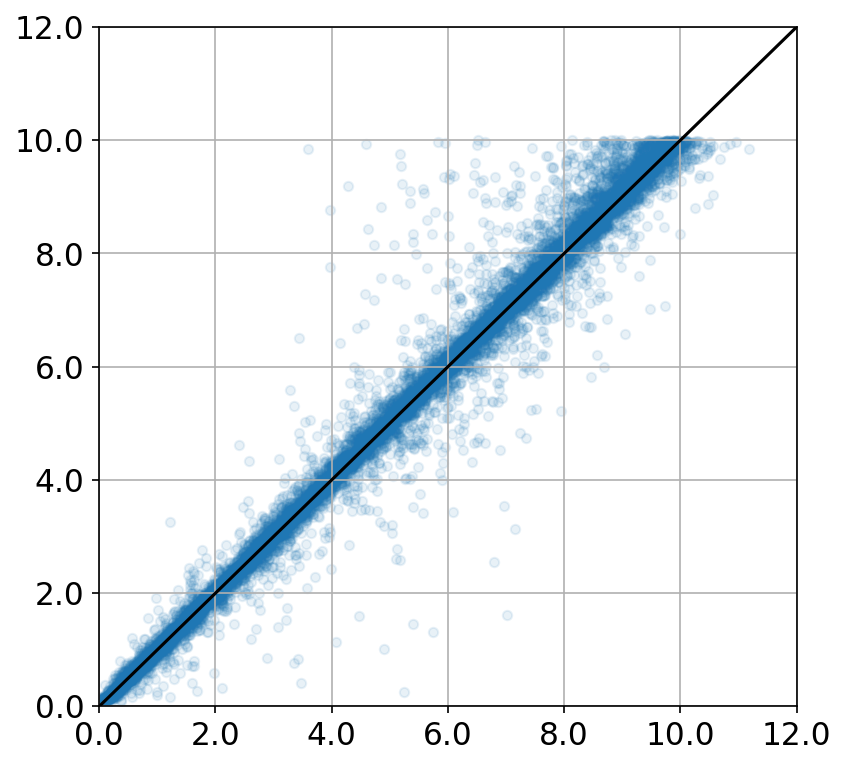

In [116]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(eval_preds[:,3],test_ydata[:,3],s=20, alpha=0.1)
plt.grid()
plt.plot([0,12],[0,12],color='black')
plt.xlim(0,12)
plt.ylim(0,12)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=7)
plt.locator_params(axis='x',nbins=7)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
plt.show()

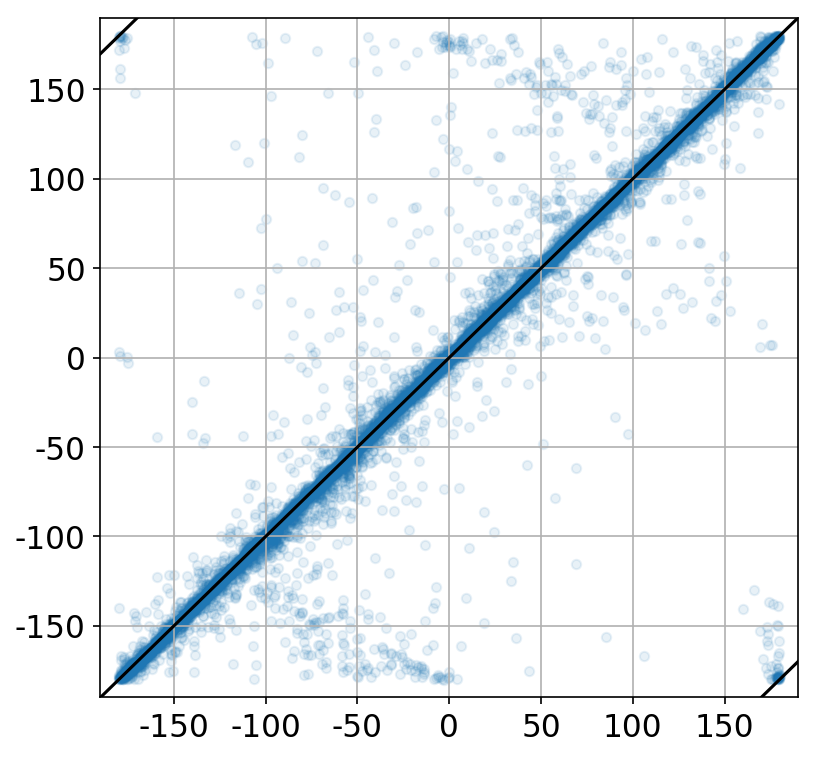

In [119]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(D_kaku,y_val_kaku,s=20, alpha=0.1)
plt.plot([-190,190],[-190,190],color='black')
plt.plot([-190,-170],[170,190],color='black')
plt.plot([170,190],[-190,-170],color='black')
plt.grid()
plt.xlim(-190,190)
plt.ylim(-190,190)
plt.tick_params(labelsize=15)
plt.locator_params(axis='y',nbins=8)
plt.locator_params(axis='x',nbins=8)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
plt.show()

In [120]:
f=open("入力応答と推定結果.csv","w")
for i in range(len(test_indices)):
    for j in range(1141):
        f.write(str(a_df[test_indices[i]][j])+",")
    f.write(str('%03.6f' %(eval_preds[i][0]))+","+str('%03.6f' %(eval_preds[i][1]))+","+str('%03.6f' %(eval_preds[i][2]))+","+str('%03.6f' %(eval_preds[i][3]))+","+str('%03.6f' %(eval_preds[i][4]))+",")
    f.write('\n')
f.close()
print("inputも終了")

inputも終了


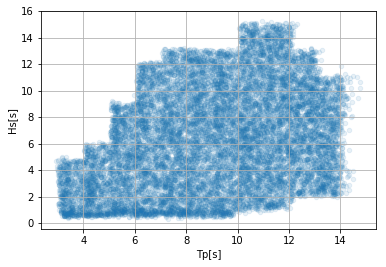

In [189]:
omega_m=np.array(eval_preds[:,4])
H_s=np.array(eval_preds[:,0])
plt.scatter(2*np.pi/omega_m,H_s,s=20, alpha=0.1)
plt.xlabel("Tp[s]")
plt.ylabel("Hs[s]")
plt.grid()
plt.show()

## 波高・波周波数・尖度の相関係数

In [122]:
retsu=0
def corre_factor(retsu):
    X=np.array(eval_preds[:,retsu])
    Y=np.array(test_ydata[:,retsu])
    E_xx=np.sum((X-np.mean(X))**2)
    E_yy=np.sum((Y-np.mean(Y))**2)
    E_xy=np.sum((X-np.mean(X))*(Y-np.mean(Y)))
    return E_xy/np.sqrt(E_xx)/np.sqrt(E_yy)
df=pd.DataFrame([['Singnificant wave height',corre_factor(0)],['kurtosis',corre_factor(3)],['modal wave frequency',corre_factor(4)]])
print(df)

                          0         1
0  Singnificant wave height  0.999604
1                  kurtosis  0.991157
2      modal wave frequency  0.999079


## 波向の相関係数はFisherの相関係数を導入

In [123]:
Sxy,Sxx,Syy=0,0,0
sin_est=np.array(eval_preds[:,2])
cos_est=np.array(eval_preds[:,1])
sin_tar=np.array(test_ydata[:,2])
cos_tar=np.array(test_ydata[:,1])
for i in range(len(eval_preds[:,4])-1):
    for j in range(i+1,len(eval_preds[:,4])):
        Sxy +=math.sin(math.atan2(sin_est[i],cos_est[i])-math.atan2(sin_est[j],cos_est[j] ))*math.sin(math.atan2(sin_tar[i],cos_tar[i])-math.atan2(sin_tar[j],cos_tar[j]))
        Sxx += math.sin(math.atan2(sin_est[i],cos_est[i] )-math.atan2(sin_est[j],cos_est[j] ))**2
        Syy += math.sin(math.atan2(sin_tar[i],cos_tar[i] )-math.atan2(sin_tar[j],cos_tar[j] ))**2

Rc=Sxy/(math.sqrt(Sxx*Syy))
print(Rc)

0.9157588333836412


## 平均誤差とその分散

In [185]:
a=[-theta_diff if np.abs(theta_diff) <=180 else np.abs(theta_diff)/(theta_diff)*(360-np.abs(theta_diff)) for theta_diff in (np.arctan2(sin_est,cos_est)-np.arctan2(sin_tar,cos_tar))*180/np.pi]
df=pd.DataFrame({'Hs1':eval_preds[:,0]-test_ydata[:,0],
                 'λ1':eval_preds[:,3]-test_ydata[:,3],
                 'ωm1':eval_preds[:,4]-test_ydata[:,4],
                 'θm1':a})#cos_est*cos_tar+sin_est*sin_tar
print(df.describe())

                Hs1            λ1           ωm1           θm1
count  14000.000000  14000.000000  14000.000000  14000.000000
mean       0.084313     -0.045192     -0.006344     -0.513832
std        0.079812      0.381504      0.014682     20.938325
min        0.000008     -6.248032     -0.285832   -179.519639
25%        0.033205     -0.122882     -0.010022     -1.387406
50%        0.068542     -0.030519     -0.005954     -0.165406
75%        0.112367      0.053444     -0.002081      1.016638
max        1.593520      5.393486      0.216590    179.504068


## 絶対値誤差の95%パーセンタイル計算(95th percentile)

In [188]:
df=pd.DataFrame({'Hs1':np.abs(eval_preds[:,0]-test_ydata[:,0]),
                 'λ1':np.abs(eval_preds[:,3]-test_ydata[:,3]),
                 'ωm1':np.abs(eval_preds[:,4]-test_ydata[:,4]),
                 'θm1':[np.arccos((cos_est[i]*cos_tar[i]+sin_est[i]*sin_tar[i])/np.sqrt(cos_est[i]**2+sin_est[i]**2)/np.sqrt(cos_tar[i]**2+sin_tar[i]**2))*180/np.pi for i in range(14000)]})#np.arccos(cos_est*cos_tar+sin_est*sin_tar)*180/np.pi
df.quantile(0.95)

Hs1     0.211559
λ1      0.644755
ωm1     0.027184
θm1    22.160554
Name: 0.95, dtype: float64

In [195]:
Results=pd.DataFrame([['Hs1[m]',0.9996,0.2115,0.04680,0.1062],
                     ['λ1',0.9991,0.6447,-0.04519,0.3815],
                     ['ωm1[rad/s]',0.9991,0.02718,-0.006344,0.01468],
                    ['θm1[deg]',0.9158,22.16,-0.5138,20.93]],
                     columns=['Sea state parameter','Correlation factor','95th percentile of absolute error','Mean of error','Std of error'],
                    index=None)


In [198]:
Results

,Sea state parameter,Correlation factor,95th percentile of absolute error,Mean of error,Std of error
0,Hs1[m],0.9996,0.21150,0.046800,0.10620
1,λ1,0.9991,0.64470,-0.045190,0.38150
2,ωm1[rad/s],0.9991,0.02718,-0.006344,0.01468
3,θm1[deg],0.9158,22.16000,-0.513800,20.93000
